In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

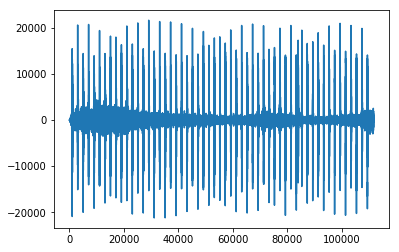

In [2]:
from scipy.io.wavfile import read
noise = np.array(read('./data/iono-othr1.wav')[1], dtype=np.float)
plt.plot(noise)
plt.show()

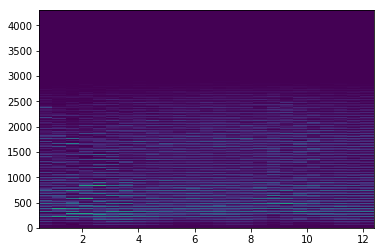

In [3]:
T = 13
fs = float(len(noise)) / T

f_noise, t_noise, Sxx_noise = scipy.signal.spectrogram(noise, fs=fs, window='nuttall',
                                     noverlap=256*8*2, nperseg=512*8*2,
                                     nfft=2048*16*8)
plt.pcolormesh(t_noise, f_noise, Sxx_noise)
plt.show()

/home/rtse/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


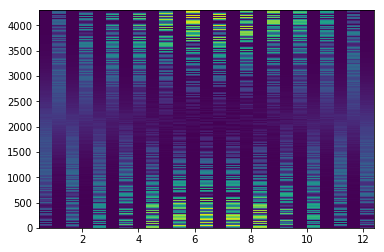

In [4]:
ts = np.linspace(0, T, T*fs, endpoint=False)
chirp = scipy.signal.chirp(ts, f0=2e6, t1=128*16, f1=20e6, method='linear')
sig = chirp + noise * 1e-5

f, t, Sxx = scipy.signal.spectrogram(sig, fs=fs, window='nuttall',
                                     noverlap=256*8*2, nperseg=512*8*2,
                                     nfft=2048*16*8)
plt.pcolormesh(t, f, Sxx)
plt.show()

In [5]:
delayed = scipy.signal.chirp(ts, f0=2e6, t1=128*16,
                             f1=20e6, method='linear')
delayed = np.array([0] * 600 + list(delayed[600:]))

# f_delayed, t_delayed, Sxx_delayed = scipy.signal.spectrogram(delayed, fs=fs, window='nuttall',
#                                      noverlap=256*8*2, nperseg=512*8*2,
#                                      nfft=2048*16*8)

# ax2.pcolormesh(t_delayed, f_delayed, Sxx_delayed)

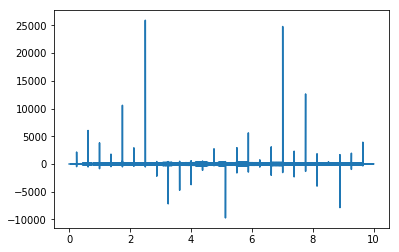

In [6]:
cor = scipy.signal.convolve(sig, delayed)
plt.plot(np.linspace(0, 10, len(cor)), cor)
plt.show()